# Perception

## Image Processing

Image processing is a computation process that transforms one or more input images into an output image, and it is the foundation of feature extraction, which is a key aspect of robotics.

Images can be represented as rectangular arrays of picture elements (pixels). In computers, we use matrices to represent such arrays. In robotics the source of these images is a camera, however, for this example we will use existing images loaded from memory.

We will start by implementing some of the algorithms covered in class by hand, and we will show how to do the same using the Open Source Computer Vision Library(OpenCV).

### Python Imaging Library (PIL)

A good start point is to use the PIL library, which provides the APIs to get an image and access the pixels.


In [ ]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

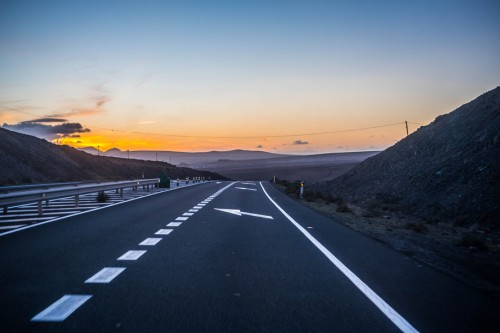

In [ ]:
def get_image_from_url(url, im_name):
  try:
    img_resp = requests.get(url , timeout = 1)
    fh = open( im_name , 'wb')
    fh.write( img_resp.content )
  except:
    print('Error while getting the image')
  return Image.open( im_name )

def show_img(im,gray=False):
    fig, ax = plt.subplots(figsize=(10,10))
    if gray:
        ax.imshow(im,cmap='gray')
    else:
        ax.imshow(im)

im = get_image_from_url('https://www.ticketsnipers.com/assets/traffic_ticket/_small_citation_photo/CVC_21460.5.jpg','test_img.png')
im

In [ ]:
# Convert PIL object into numpy array to ease the processing
np_im = np.array(im)
print('PIL Image format WxH: {}'.format(im.size))
print('NumPy Image format HxWxC: {}'.format(np_im.shape))

PIL Image format WxH: (500, 333)
NumPy Image format HxWxC: (333, 500, 3)


In [ ]:
# Process Image (Make black the columnns 0 to 10)
np_im[:,0:10,:] = 0;

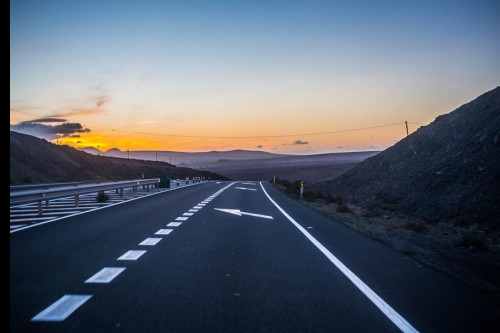

In [ ]:
# Convert back to PIL Object
im_processed = Image.fromarray(np_im, 'RGB')
im_processed.save('test_img_proc.png')
im_processed

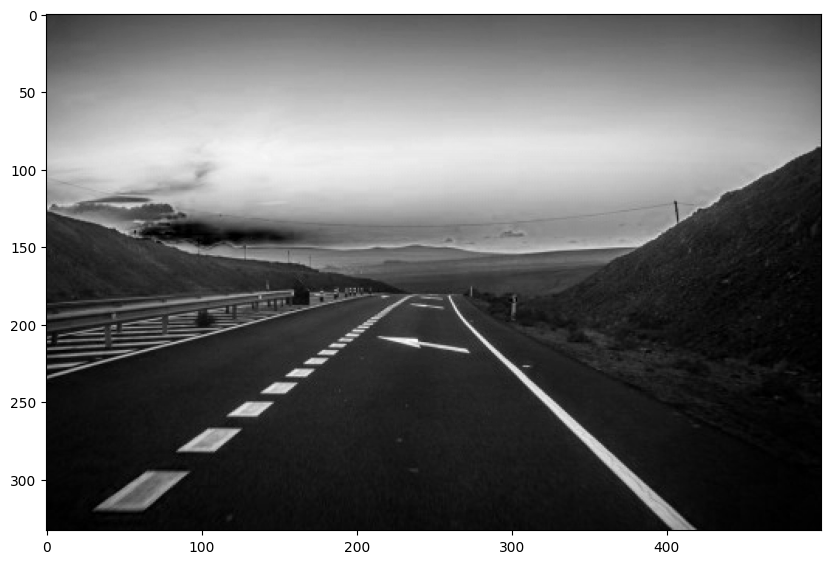

In [ ]:
# Convert into a numpy array and make the image a grayscale image
np_im = np.array(im)
np_im_gray = np_im.min(axis=2)
show_img(np_im_gray,True)

### Image Convolution
A very important linear spatial operator is the convolution.
![conv.png](attachment:conv.png)

$$
\mathbf{O}[u,v]=\sum_{(i,j)\in \mathcal{W}}\mathbf{I}[u+i,v+j]\mathbf{K}[i,j] \\ \forall(u,v) \in \mathbf{I}
$$

where $\mathbf{K}\in\mathbb{R}^{w\times w}$ is the kernel. For every output pixel the corresponding window of pixels from the input image $\mathcal{W}$ is multiplied wlement wise with the kernel $\mathbf{K}$. The
centre of the window and kernel is considered to be coordinate $(0,0)$ and $i,j \in [-h,h]$. When $\mathbf{K}$ is not symmetric, the kernel has to be flipped bot around its horizontal and vertical axis before doing the element-wise multiplication.
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/570600fdeed436d98626278f22bf034ff5ab5162'>

In [ ]:
def get_sub_matrix(m,xy,sub_size):
  """
  Get the a submatrix of size:sub_size centered at xy
  from matrix m.
  """
  x,y = xy
  sx,sy = sub_size
  padx, pady = int(sx/2), int(sy/2)
  out = np.zeros(sub_size)
  # Get the elements to build the desired sub-matrix from m
  out = m[x-padx:x+padx+1,y-pady:y+pady+1]
  return out

def convolve_image(im, k):
  """
  Convolve kernel k with image im.
  """
  k = np.flip(k)
  k_x,  k_y  = k.shape
  dx, dy = int(k_x/2),int(k_y/2)
  im_x, im_y = im.shape

  # Shape of resulting output image
  im_out_x = int((im_x - k_x) + 1)
  im_out_y = int((im_y - k_y) + 1)
  im_out = np.zeros((im_out_x, im_out_y),dtype=np.float32)

  for x in range(im_x):
    for y in range(im_y):
      if (x >= dx) and (y >= dy):
        sub_m = get_sub_matrix(im,(x,y),k.shape)
        # convolve for a given pixel
        im_out[x-dx,y-dy] = np.einsum('ij,ij->i', sub_m, k).sum()
      # Break if the height has been reached
      if y > im_y - dy - 2:
        break
    # Break if the width has been reached
    if x > im_x - dx - 2:
      break
  return im_out

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def avg_kernel(size):
  return np.ones((size,size))/size**2

def blur_box_filter_3x3(im):
  G_b_3x3 = gaussian_kernel(3)
  im_out = convolve_image(im,G_b_3x3)
  return im_out.astype(np.uint8)

def blur_box_filter_5x5(im):
  G_b_5x5 = gaussian_kernel(5)
  im_out = convolve_image(im,G_b_5x5)
  return im_out.astype(np.uint8)

def identity_kernel(size):
    k = np.zeros(size)
    k[tuple([i//2 for i in k.shape])]=1;
    return k

#### Operations with Different Kernels
##### Identity
$$
K_{Identity} = \begin{bmatrix}
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0
\end{bmatrix}
$$

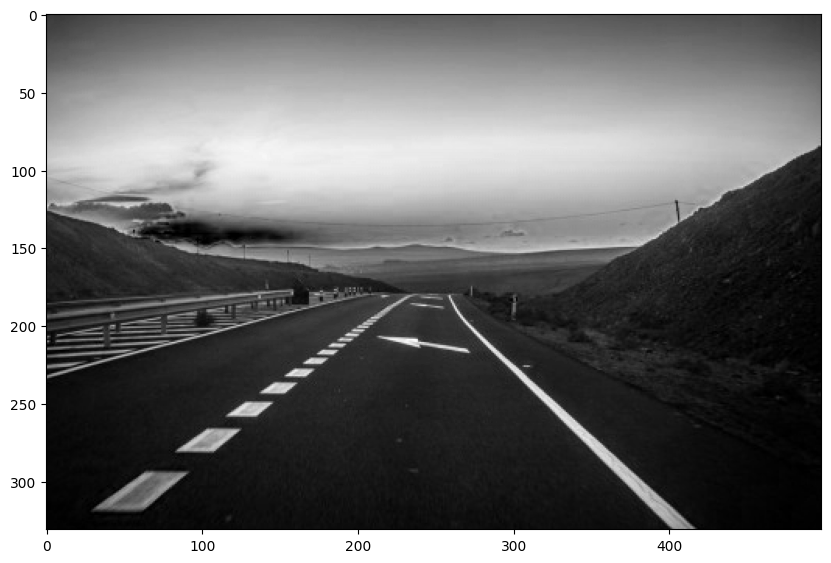

In [ ]:
k_i = identity_kernel((3,3))
I = np_im_gray
filt_img = convolve_image(I,k_i)
show_img(filt_img,True)

##### Sharpen
$$
K_{Sharpen} = \begin{bmatrix}
0 & -1 & 0\\
-1 & 5 & -1\\
0 & -1 & 0
\end{bmatrix}
$$

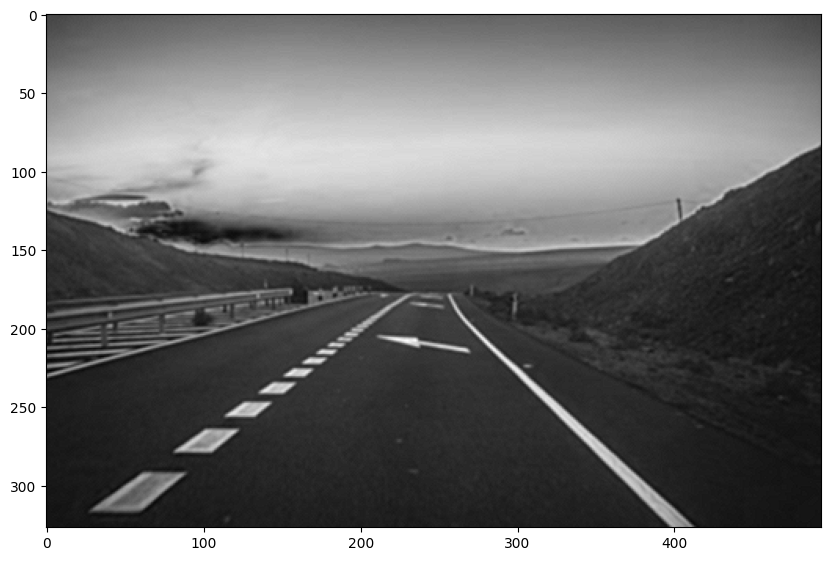

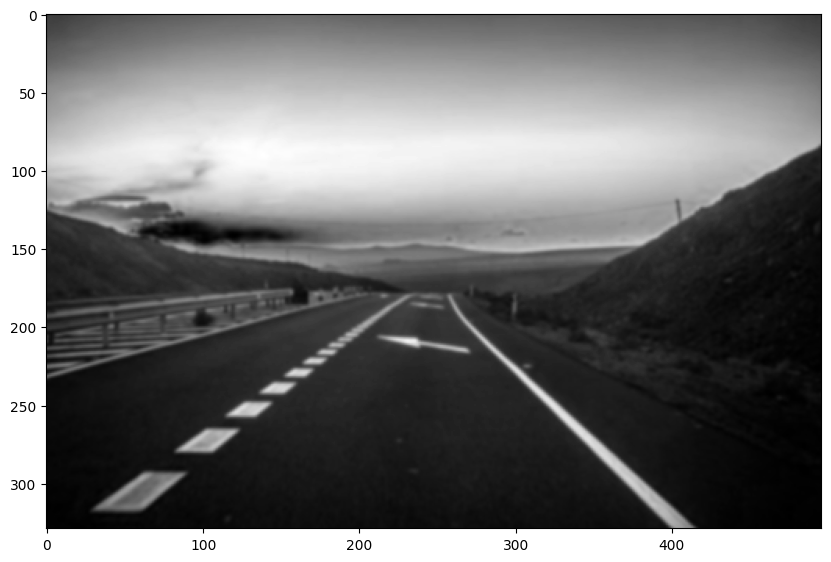

In [ ]:
k_s = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], np.float32)
im_gb5x5 = blur_box_filter_5x5(np_im_gray)
I = im_gb5x5
filt_img = convolve_image(I,k_s)
show_img(filt_img,True)
show_img(I,True)

#### The Sobel Filter

It is a commonly used filter to do edge detection. The output of the filter is an image that emphazises the edges of the original image. It implements two kernels to look for edges in the $x$ and $y$ dirtections.

$$
G_y =\begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix}
,
G_x =\begin{bmatrix}
    -1 & 0 & 1 \\
    -2 & 0 & 2 \\
    -1 & 0 & 1
\end{bmatrix}
$$

Finally the two resulting images can be combined to find the filtered output following this equations:
$$
G = \sqrt{G_x^2+ G_y^2}
$$

Another important information that can be extracted from the sobel filter is the angle associated to the gradient:
$$
\theta = \arctan{\frac{G_y}{G_x}}
$$
This latter is used in as part of the Canny edge dection.

In [ ]:
#define sobel filter based on the previously defined functions
def sobel_filter(im):
  G_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)
  G_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)
  im_proc_x = convolve_image(im,G_x)
  im_proc_y = convolve_image(im,G_y)
  # Initialize arrays
  mag = np.zeros(im_proc_x.shape,dtype=np.uint8)
  theta = np.zeros(im_proc_x.shape,dtype=np.float32)
  # Calculate the output matrices
  mag = np.sqrt(im_proc_x**2+im_proc_y**2)
  theta = np.arctan2(im_proc_y,im_proc_x)
  return theta,im_proc_x,im_proc_y,mag

In [ ]:
im_gb5x5 = blur_box_filter_5x5(np_im_gray)
theta,im_proc_x, im_proc_y, mag = sobel_filter(im_gb5x5)

Text(0.5, 1.0, 'Sobel Filter Magnitude')

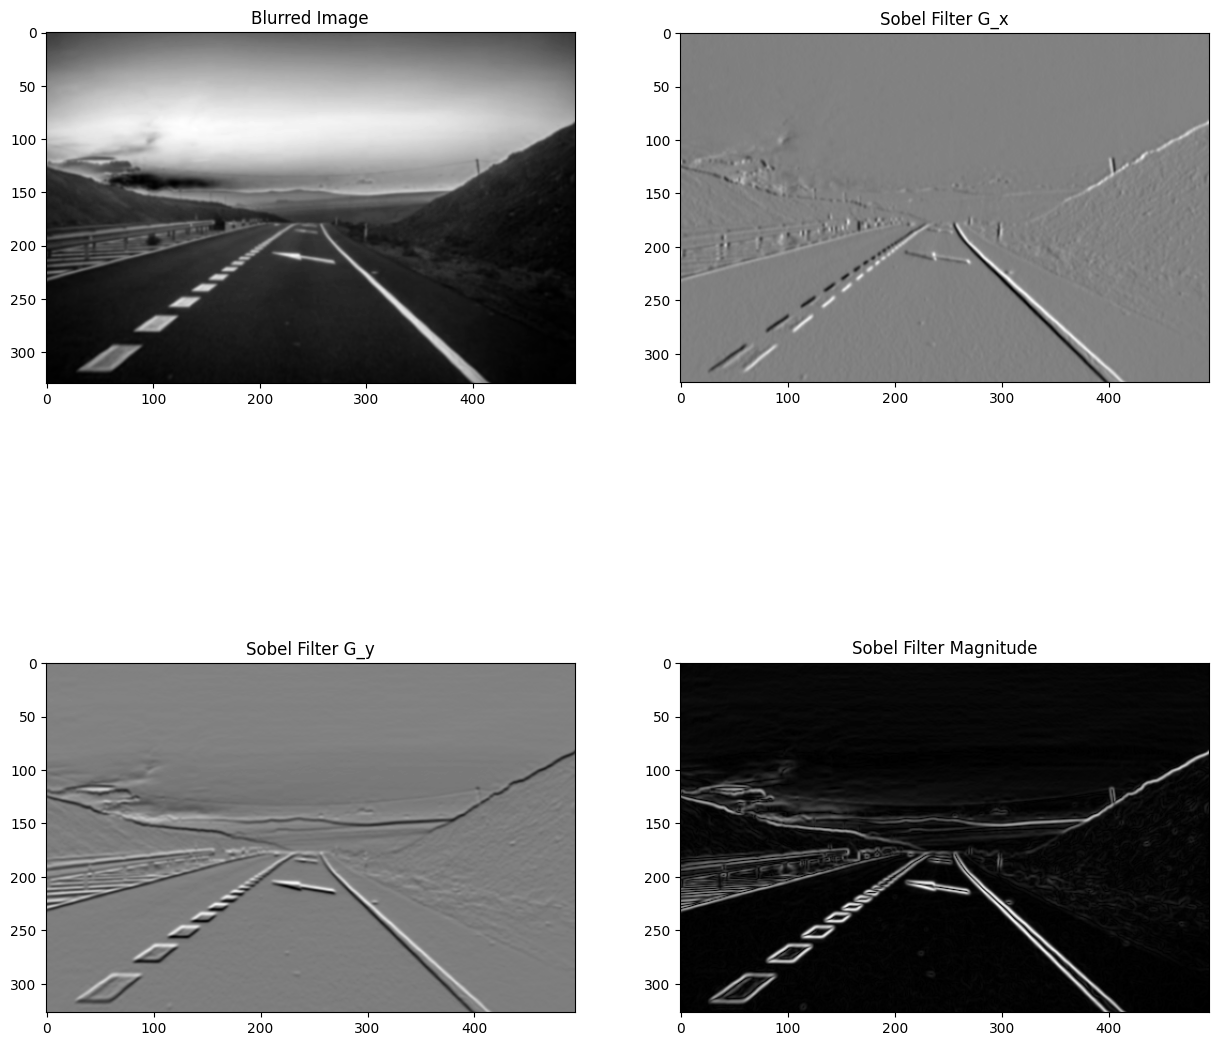

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))

axs[0,0].imshow(im_gb5x5,cmap='gray')
axs[0,0].set_title('Blurred Image')

axs[0,1].imshow((im_proc_x+np.min(im_proc_x))*255/(np.max(im_proc_x)-np.min(im_proc_x)),cmap='gray')
axs[0,1].set_title('Sobel Filter G_x')

axs[1,0].imshow(im_proc_y,cmap='gray')
axs[1,0].set_title('Sobel Filter G_y')

axs[1,1].imshow(mag,cmap='gray')
axs[1,1].set_title('Sobel Filter Magnitude')

### Canny Edge Detector
For the canny edge detector, a couple more of steps are required. As part of the sobel filtering, we obtained one edge gradient image in grayscale. We will use this image, remove noise and extract the strongest edges to keep them in the final image. These two steps are called:

* Non-Maximum Supression
* Hyseresis Thresholding

#### Non-Maximum Supression
The purpose of this step is to remove non-necessary information, in other words, anything that is not part of the edge. This is achieved by finding if the pixel being processed is the maximum in the gradient direction.

Lets consider the example in the image below(taken from the OpenCV documentation). In this case, the pixel $A$ is being processed, $B$ and $C$ are on the gradient direction (perpendicular to the edge direction). So if $A >B$ and $A > C$ that means that $A$ is part of the edge, and then it is preserved for the next stage.

<img src='https://docs.opencv.org/master/nms.jpg'>

#### Hyseresis Thresholding
This is the final stage for the Canny Edge detector. Here, the idea is to eliminate any remaining weak edges either by intensity or if they are not connected to other edges.

The idea is to generate 3 intensity levels:
* $p[i,j]\geq MaxVal$ are considered as part of the final image.
* $MinVal<p[i,j]<MaxVal$ are considered as part of the final image only if they are connected to other pixels in the first region.
* $p[i,j]\leq MinVal$ are excluded from the final stage.



In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    # Transform radians to degrees for easier processing
    # The output value will be [-pi,pi]
    angle = D * 180. / np.pi
    angle = angle%360
    #reflect over the x axis
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                a = img[i,j]
                b = 255.0
                c = 255.0

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    b = img[i, j+1]
                    c = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    b = img[i+1, j-1]
                    c = img[i-1, j+1]

                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    b = img[i+1, j]
                    c = img[i-1, j]

                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    b = img[i-1, j-1]
                    c = img[i+1, j+1]


                if (a >= b) and (a >= c):
                    Z[i,j] = a
                else:
                    Z[i,j] = 0

            except IndexError as e:
                print('Error Found')

    return Z

In [ ]:
im_nms = non_max_suppression(mag,theta)

Text(0.5, 1.0, 'Non-Maximum Supression')

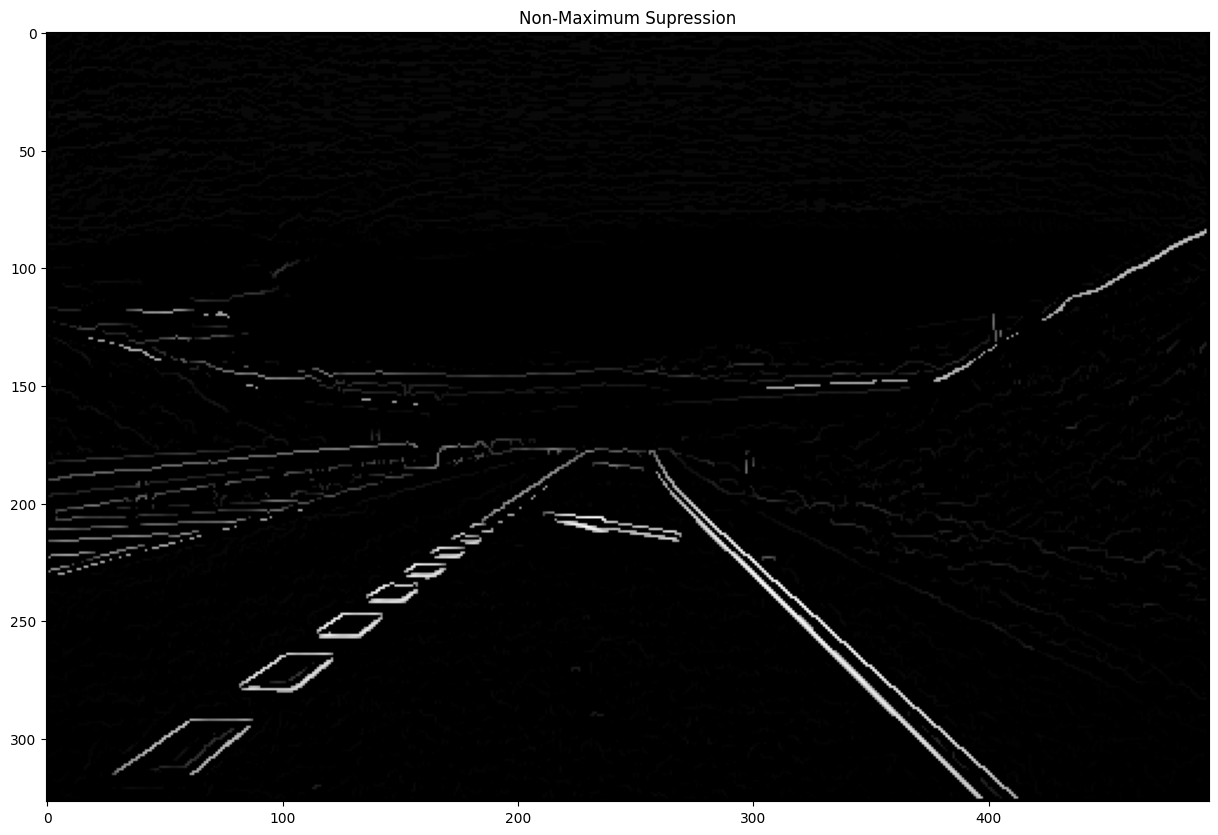

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(im_nms,cmap='gray')
ax.set_title('Non-Maximum Supression')

In [ ]:
def hyst_threshold(im, lt_r=0.1, ut_r=0.5):
    # Scale the thresholds according to the values in the input image
    ut_value = im.max() * ut_r;
    lt_value = ut_value * lt_r;
    # Get image size and initialize output array
    M, N = im.shape
    out = np.zeros((M,N), dtype=np.int32)

    sure_edge_idx = im>ut_value
    false_edge_idx = im<lt_value
    probable_edge_idx = (im <= ut_value) & (im >= lt_value)

    # If the probabl edge is connected to a sure_edge,
    for i in range(M-1):
      for j in range(N-1):
        if (probable_edge_idx[i,j]):
          flag = False
          for ii in range(-1,2,2):
             for jj in range(-1,2,2):
               if (i+ii > 0) and (j+jj>0):
                 if (sure_edge_idx[i+ii,j+jj]):
                   flag = True
          probable_edge_idx[i,j] = flag

    out[false_edge_idx] = 0
    out[sure_edge_idx] = 255
    out[probable_edge_idx] = 255

    return out

In [ ]:
im_canny_edge_1_5 = hyst_threshold(im_nms, lt_r=0.05, ut_r=0.1)
im_canny_edge_1_6 = hyst_threshold(im_nms, lt_r=0.05, ut_r=0.2)
im_canny_edge_5_8 = hyst_threshold(im_nms, lt_r=0.1, ut_r=0.3)
im_canny_edge_6_8 = hyst_threshold(im_nms, lt_r=0.5, ut_r=0.7)

Text(0.5, 1.0, 'Canny Edge lt=0.5, ut=0.7')

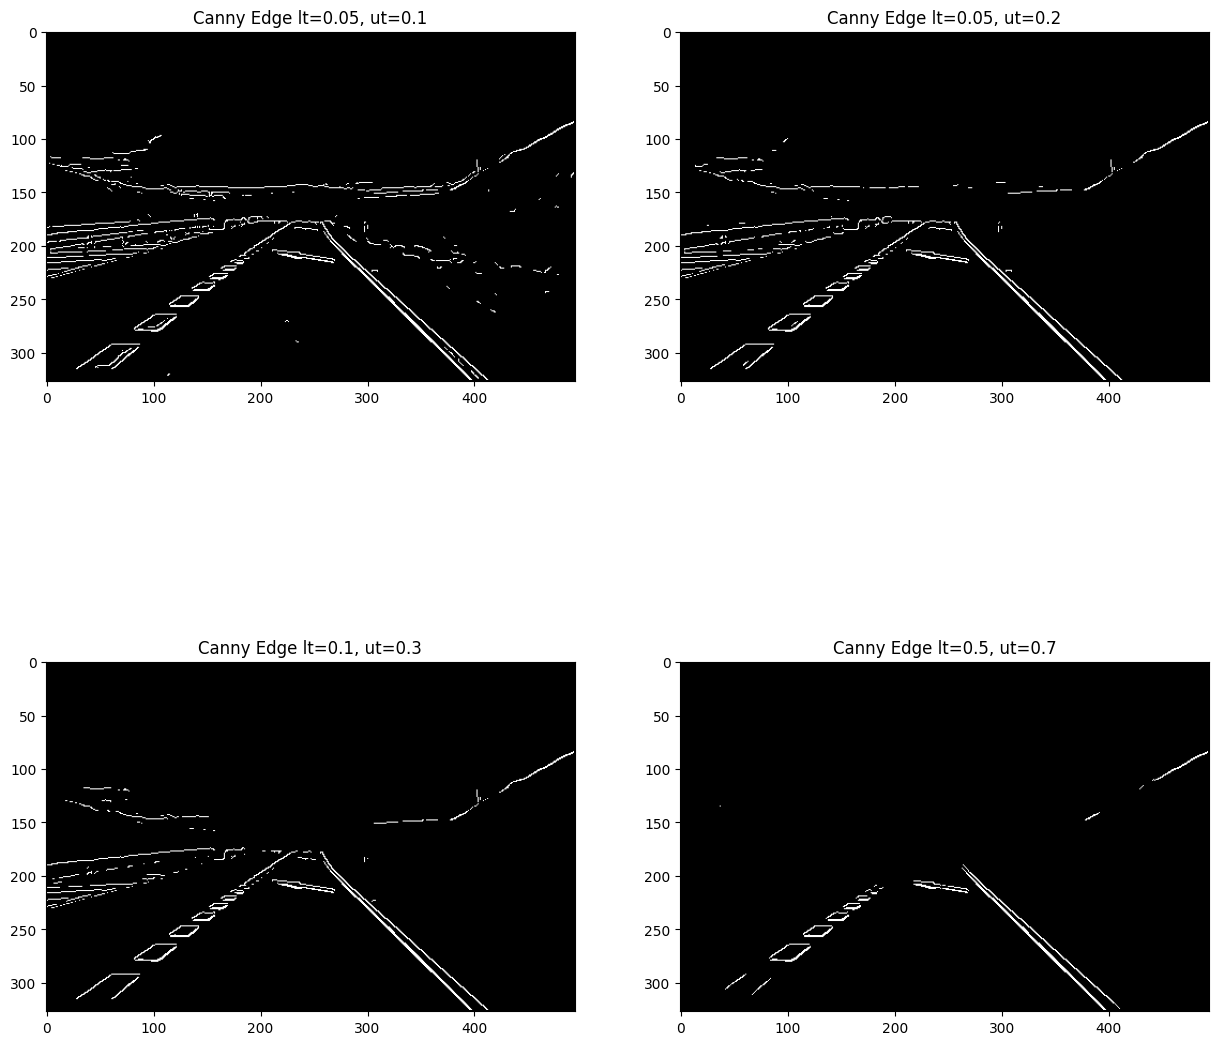

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))

axs[0,0].imshow(im_canny_edge_1_5,cmap='gray')
axs[0,0].set_title('Canny Edge lt=0.05, ut=0.1')

axs[0,1].imshow(im_canny_edge_1_6,cmap='gray')
axs[0,1].set_title('Canny Edge lt=0.05, ut=0.2')

axs[1,0].imshow(im_canny_edge_5_8,cmap='gray')
axs[1,0].set_title('Canny Edge lt=0.1, ut=0.3')

axs[1,1].imshow(im_canny_edge_6_8,cmap='gray')
axs[1,1].set_title('Canny Edge lt=0.5, ut=0.7')

## Image Processing with OpenCV

### Lane Detection
A common solution to perform more complex processing operations is to use the OpenCV library. This saves a lot of time, since the convolutiuon functions are already implemented and optimized. The following example will present an implementation for lane detection.

In order to do this, the original image will be processed as follows:
1. Gaussian blur filtering ($5\times5$ kernel)
2. Canny edge detection ($MinVal=50$ and $MaxVal=150$)
3. Extraction of ROI (Removing horizon)
4. Probabilistic Hough Transformation
5. Lane Detection


In [ ]:
import cv2
#from google.colab.patches import cv2_imshow

In [ ]:
def canny(image):
    gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY) # convert to grayscale
    blur = cv2.GaussianBlur(gray,(5,5),0) # reduce noise
    canny = cv2.Canny(blur,50,150) # Find the edges
    return gray,blur,canny

def region_of_interest(image):
    height,width = image.shape[0],image.shape[1]
    polygons = np.array([[(0,height),(width,height),(int(width/2),int(0.5*height))]])
    mask = np.zeros_like(image) # black
    cv2.fillPoly(mask,polygons,255) # white
    maskded_image = cv2.bitwise_and(image,mask)
    return mask,maskded_image

def display_line(image,lines):
    line_image = np.zeros_like(image)
    height, width, channels = image.shape
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image,(int(x1), int(y1)),(int(x2), int(y2)),(255, 0, 0), 10)#only one line

    print("width:%s,height:%s,channels:%s" % (width, height, channels))
    #cv2.line(line_image, (int(width/2), int(height)), (int(width/2), int(height*0.6)), (0, 255, 0), 10)  # only one line
    return line_image

def make_coordinate(image,line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*3/5)
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1, y1, x2, y2])

#-------------------average------------
def average_slope_intercept(image,lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2),(y1, y2),1)
        #print(parameters)
        slope = parameters[0]
        intercept = parameters[1]
        if slope<0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_coordinate(image,left_fit_average)
    right_line = make_coordinate(image,right_fit_average)
    mid_line = (left_line+right_line)/2

    return np.array([left_line,right_line,mid_line])

(333, 500, 3)


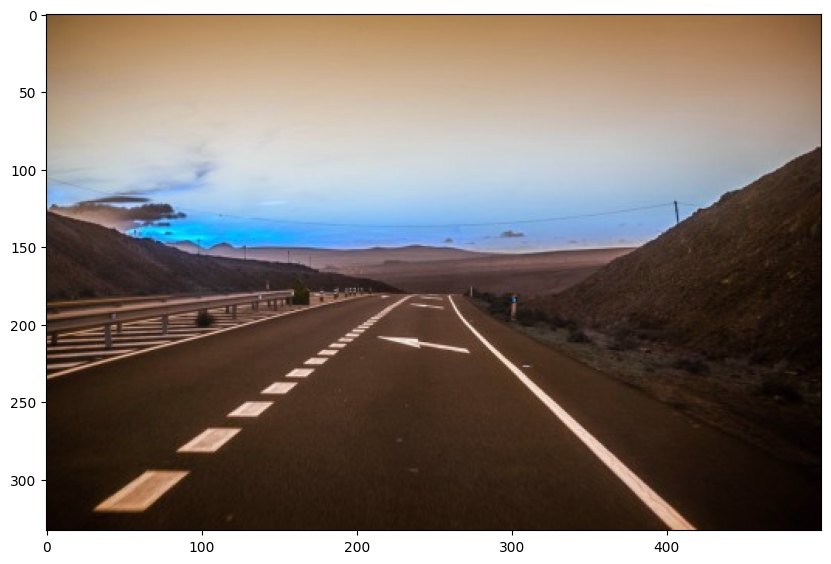

In [ ]:
lane_image = cv2.imread('test_img.png')# show the original picture
show_img(lane_image)
print(lane_image.shape)

(333, 500)


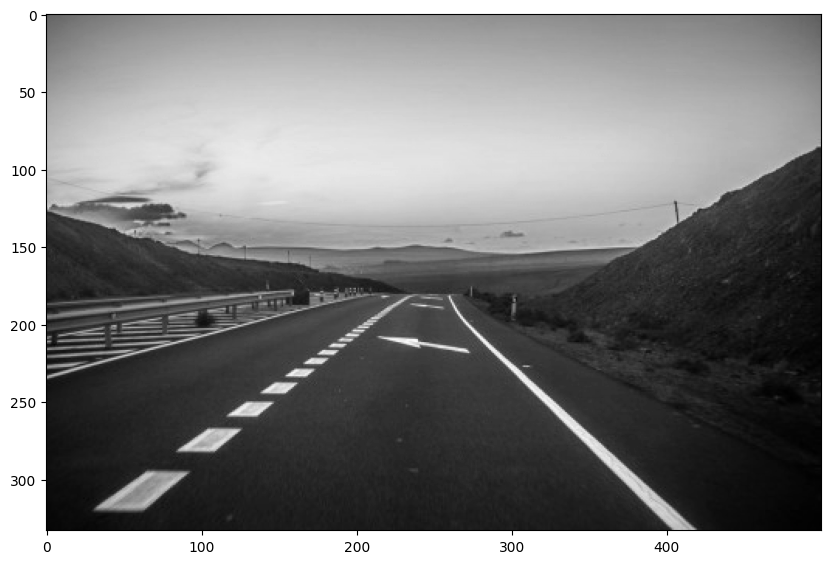

In [ ]:
gray,blur,canny_image = canny(lane_image) # convert from RGB to grayscale
show_img(gray,True)
print(gray.shape) # only has one channel


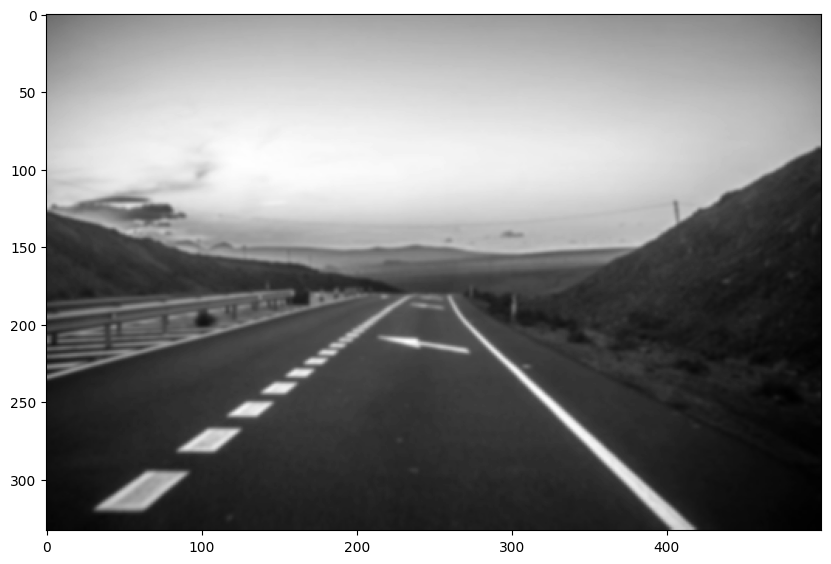

In [ ]:
show_img(blur,True) # reduce noise

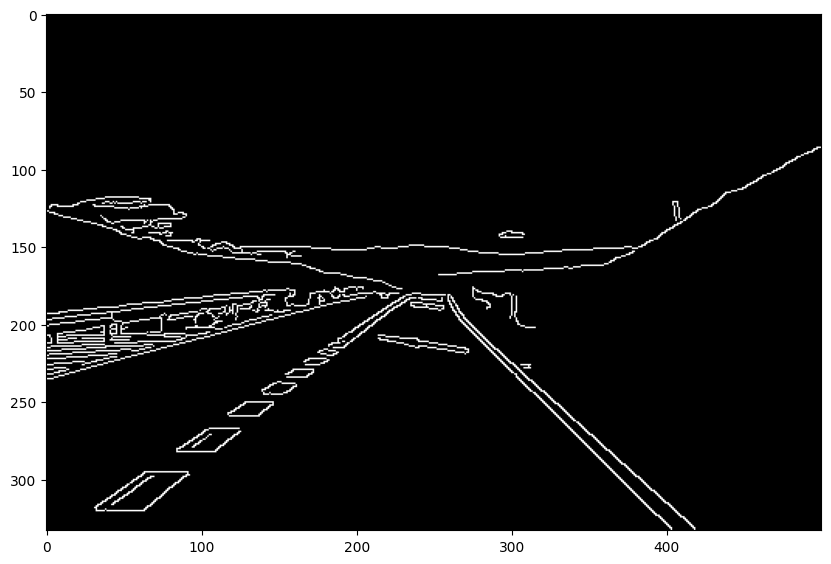

In [ ]:
show_img(canny_image,True) # show edge

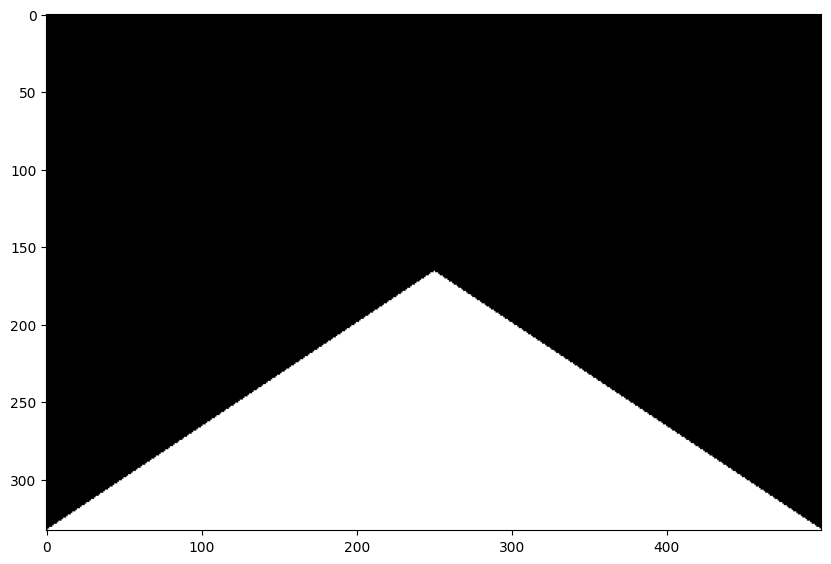

In [ ]:
mask,cropped_image = region_of_interest(canny_image)
show_img(mask,True)

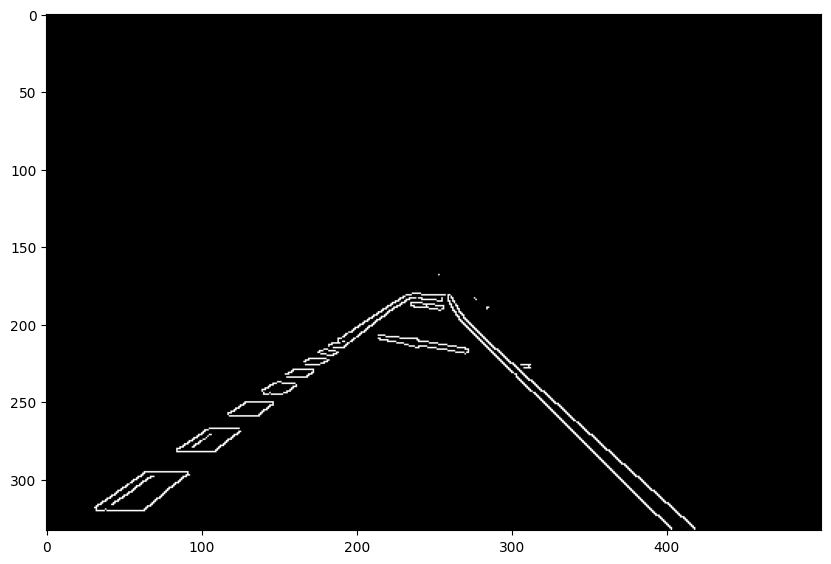

In [ ]:
show_img(cropped_image,True)# show edge

In [ ]:
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]),minLineLength=50,maxLineGap=5)#image,pixel,accuracy,threshold(votes)
print(lines) # two left lanes and two right lanes

[[[277 204 418 331]]

 [[264 194 393 323]]

 [[167 224 232 181]]

 [[155 244 221 191]]]


width:500,height:333,channels:3


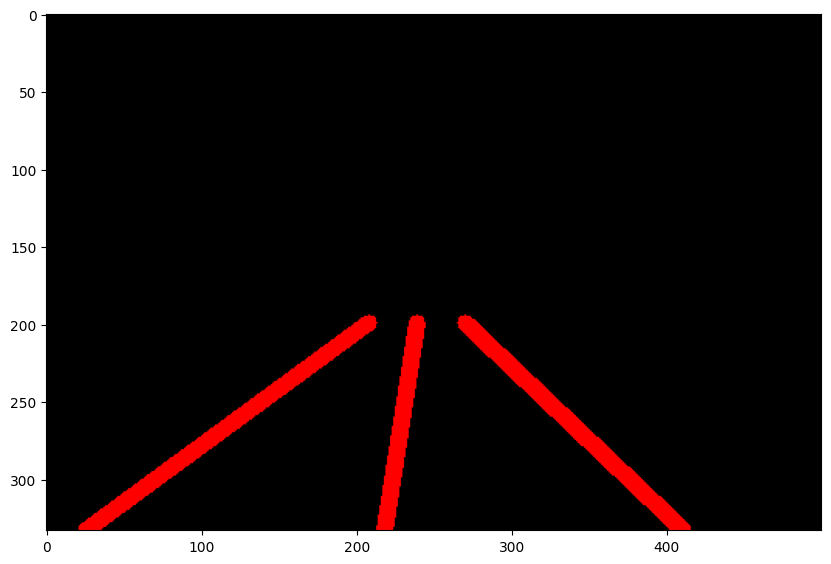

In [ ]:
average_lines = average_slope_intercept(lane_image,lines)
line_image = display_line(lane_image,average_lines)
show_img(line_image)


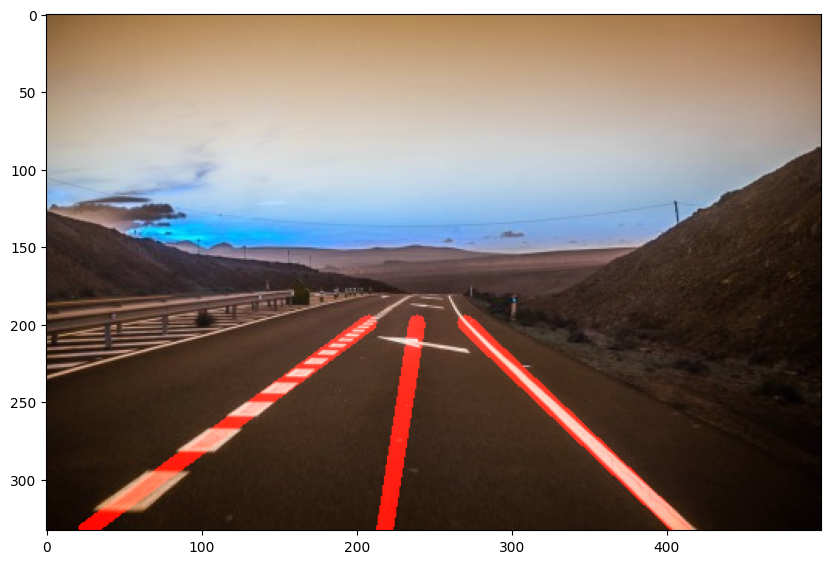

In [ ]:
combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

show_img(combo_image)

### Filter Color with OpenCV
This is a common thechinque used when color segmentation is required for a prticular task. With this technique, it is possible to implement object detection, find a specific region of an image, with a prior knowledge of the color that we are looking for. OpenCV provides the APIs to do such filtering, however, the filter that needs to be created is hard to create on a regular RGB space, for that, Hue-Saturation-Value color space is preferred.
<img src='hsv.png'>

In [ ]:
im = get_image_from_url('https://media.npr.org/assets/img/2021/09/22/img_4973-1fff64cb2be877fb9678bd9a52bee4ea1e5f03ca.jpg','color_filter.png')
im

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Source: https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv

# def nothing(x):
#     pass

# # Load image
# in_img = cv2.imread('color_filter.png')
# scale_percent = 30 # percent of original size
# width = int(in_img.shape[1] * scale_percent / 100)
# height = int(in_img.shape[0] * scale_percent / 100)
# dim = (width, height)

# # resize image
# image = cv2.resize(in_img, dim, interpolation = cv2.INTER_AREA)

# # Create a window
# cv2.namedWindow('image')

# # Create trackbars for color change
# # Hue is from 0-179 for Opencv
# cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# # Set default value for Max HSV trackbars
# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# # Initialize HSV min/max values
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# while(1):
#     # Get current positions of all trackbars
#     hMin = cv2.getTrackbarPos('HMin', 'image')
#     sMin = cv2.getTrackbarPos('SMin', 'image')
#     vMin = cv2.getTrackbarPos('VMin', 'image')
#     hMax = cv2.getTrackbarPos('HMax', 'image')
#     sMax = cv2.getTrackbarPos('SMax', 'image')
#     vMax = cv2.getTrackbarPos('VMax', 'image')

#     # Set minimum and maximum HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Convert to HSV format and color threshold
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower, upper)
#     result = cv2.bitwise_and(image, image, mask=mask)

#     # Print if there is a change in HSV value
#     if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display result image
#     cv2.imshow('image', result)
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#        break

# cv2.destroyAllWindows()

(2268, 3024, 3)
(2268, 3024)


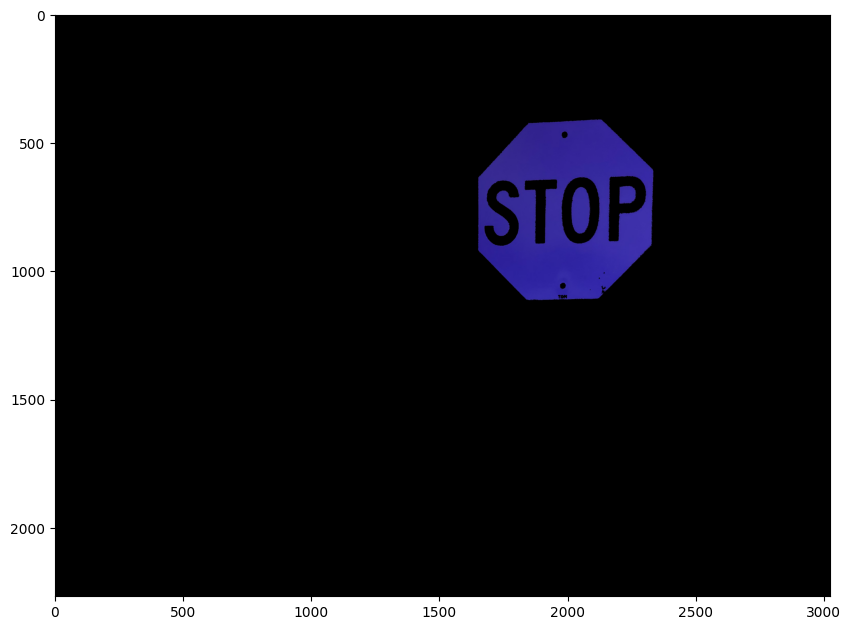

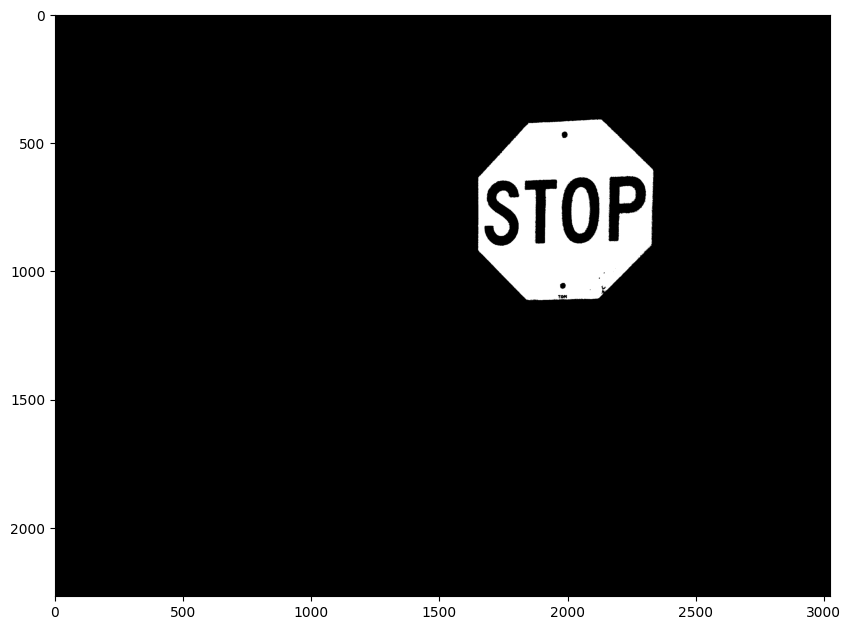

In [ ]:
img = cv2.imread('color_filter.png')
lower = np.array([144, 168, 118])
upper = np.array([179, 255, 255])

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower, upper)
result = cv2.bitwise_and(img, img, mask=mask)
print(img.shape)
show_img(result)
print(mask.shape)
show_img(mask,True)



### Blob Detection

The idea behind blob detection is to identify connected regions of pixel that share different characteritics such as:
- Color intensity (grayscale)
- Inertia
- Convexity
- Area

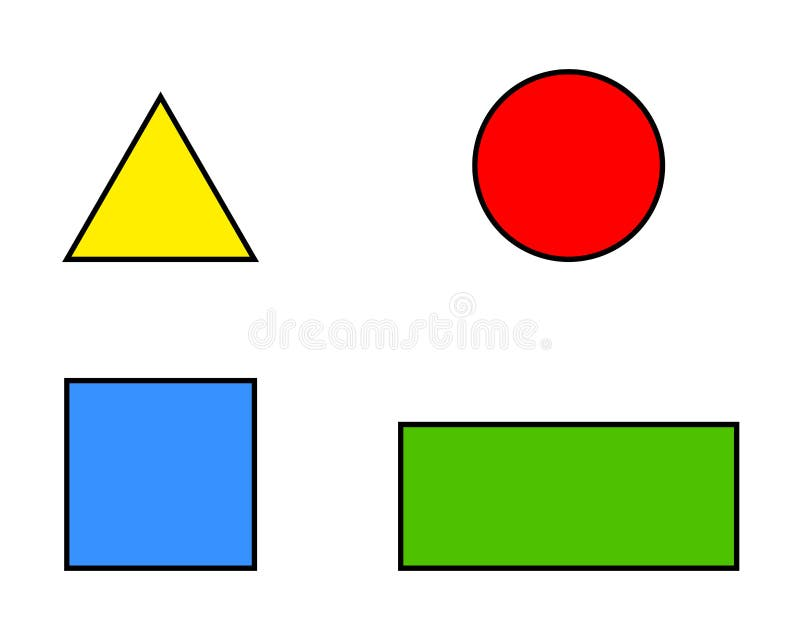

In [ ]:
img = get_image_from_url('https://thumbs.dreamstime.com/b/geometric-basic-shape-triangle-circle-square-rectangle-vector-illustration-isolated-white-background-196364584.jpg','blob_input.png')
img

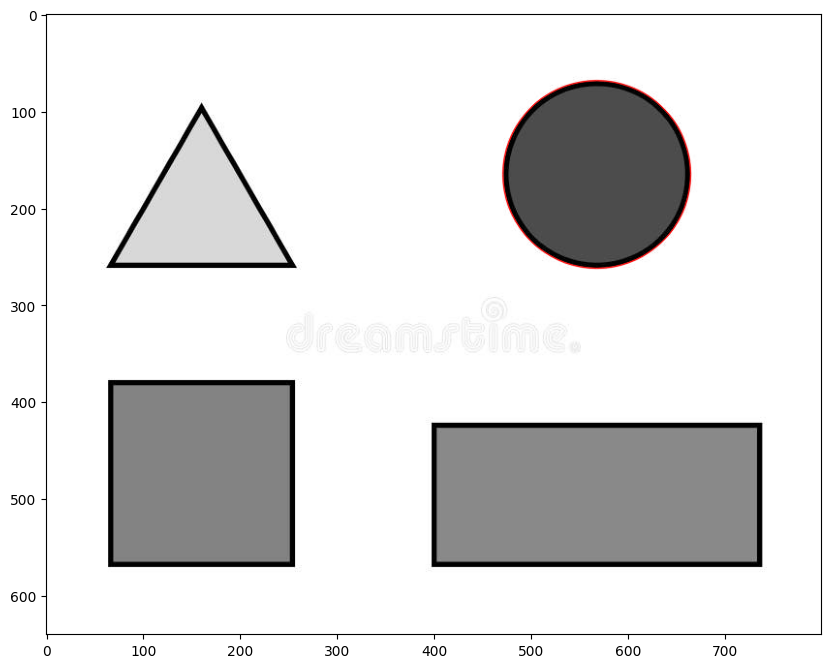

In [70]:
# Source: https://learnopencv.com/blob-detection-using-opencv-python-c/
# Setup SimpleBlobDetector parameters.
img = cv2.imread('blob_input.png',0)
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 200;

# Filter by Area.
params.filterByArea = True
params.minArea = 100
params.maxArea = 100000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.7
params.maxCircularity = 0.9

# # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.1
# params.maxConvexity = 0.999

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.maxInertiaRatio = 1.0

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else :
    detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_img(im_with_keypoints)

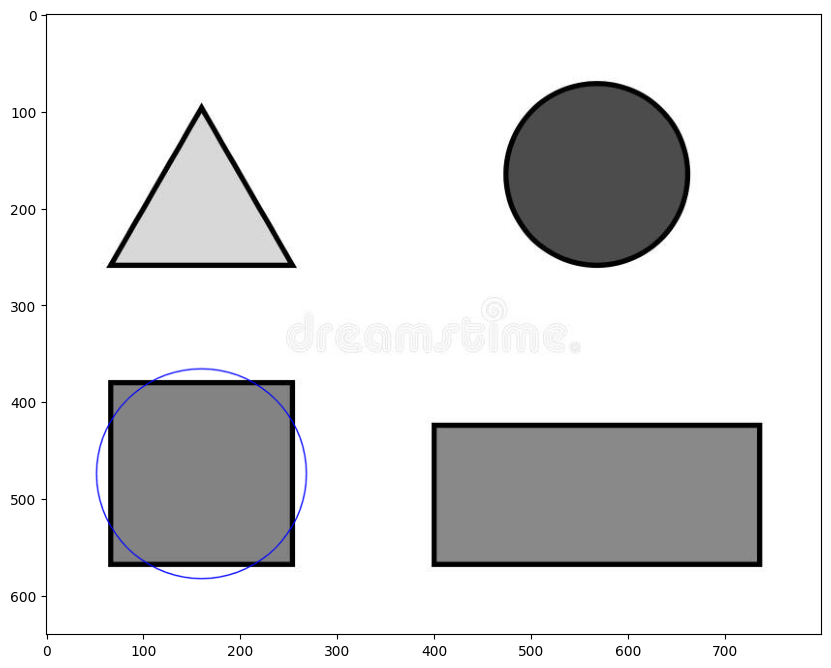

In [71]:
# Source: https://learnopencv.com/blob-detection-using-opencv-python-c/
# Setup SimpleBlobDetector parameters.
img = cv2.imread('blob_input.png',0)
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 200;

# Filter by Area.
params.filterByArea = True
params.minArea = 100
params.maxArea = 100000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.7
params.maxCircularity = 0.8

# # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.1
# params.maxConvexity = 0.999

# Filter by Inertia
# params.filterByInertia = False
# params.minInertiaRatio = 0.0
# params.maxInertiaRatio = 1.0

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else :
    detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_img(im_with_keypoints)

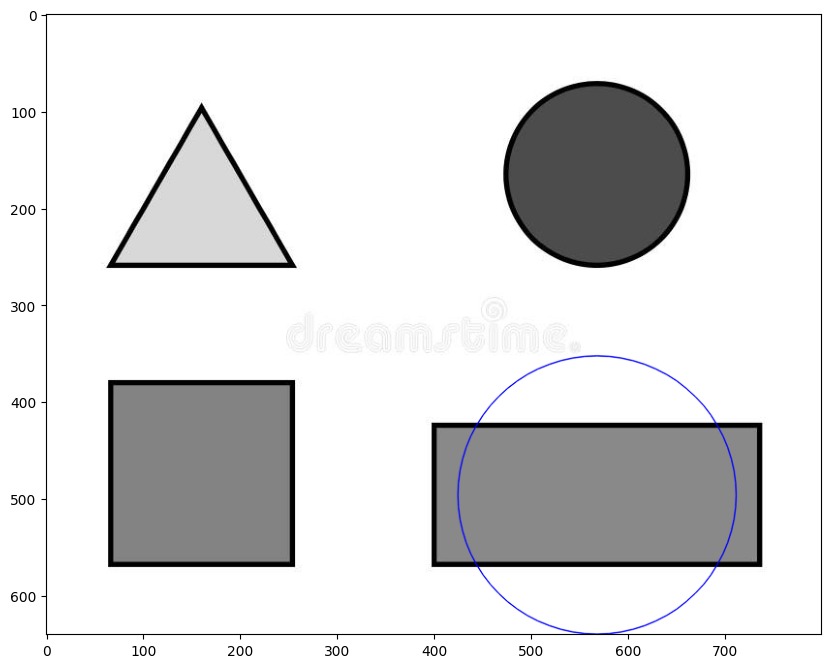

In [72]:
# Source: https://learnopencv.com/blob-detection-using-opencv-python-c/
# Setup SimpleBlobDetector parameters.
img = cv2.imread('blob_input.png',0)
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 200;

# Filter by Area.
params.filterByArea = True
params.minArea = 100
params.maxArea = 100000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.6
params.maxCircularity = 0.7

# # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.1
# params.maxConvexity = 0.999

# Filter by Inertia
# params.filterByInertia = False
# params.minInertiaRatio = 0.0
# params.maxInertiaRatio = 1.0

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else :
    detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_img(im_with_keypoints)

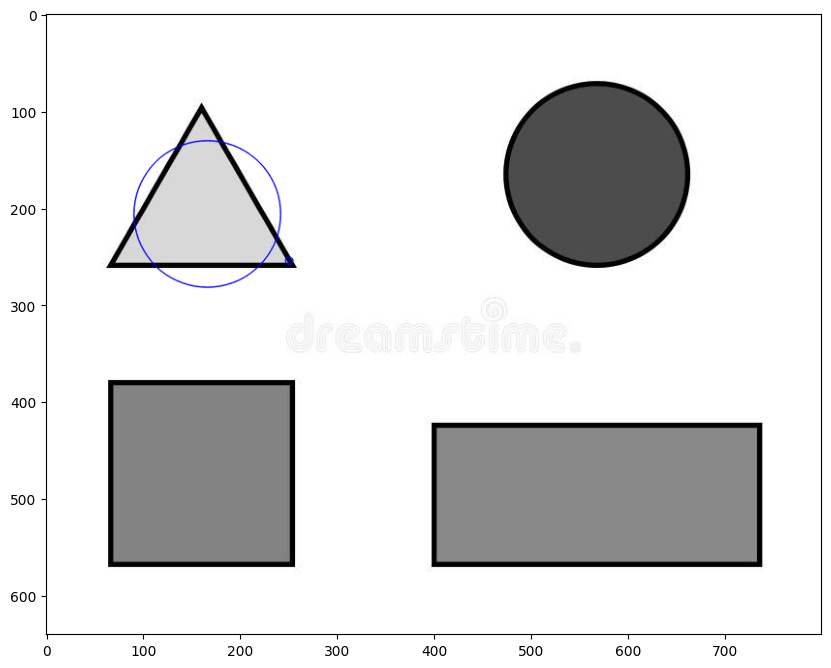

In [74]:
# Source: https://learnopencv.com/blob-detection-using-opencv-python-c/
# Setup SimpleBlobDetector parameters.
img = cv2.imread('blob_input.png',0)
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 230;

# Filter by Area.
params.filterByArea = True
params.minArea = 10
params.maxArea = 1000000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.01
params.maxCircularity = 0.7

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.5
params.maxConvexity = 0.99

# # Filter by Inertia
# params.filterByInertia = True
# params.minInertiaRatio = 0.01
# params.maxInertiaRatio = 1.0

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else :
    detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_img(im_with_keypoints)

### Find Contours
This functionality is also helpful to detect connected pixels that define a curve. In order to get better results, find contours is usually used over previously proccessed images (canny edge, bw thresholding, etc.). Find contours can be also used for object detection, by filtering different characteristics of the contours such as:
- Area.
- Perimeter.
- Aspect ratio.
- Extent.
- Solidity.
...

More information of this OpenCV functionality can be found [here](https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html).

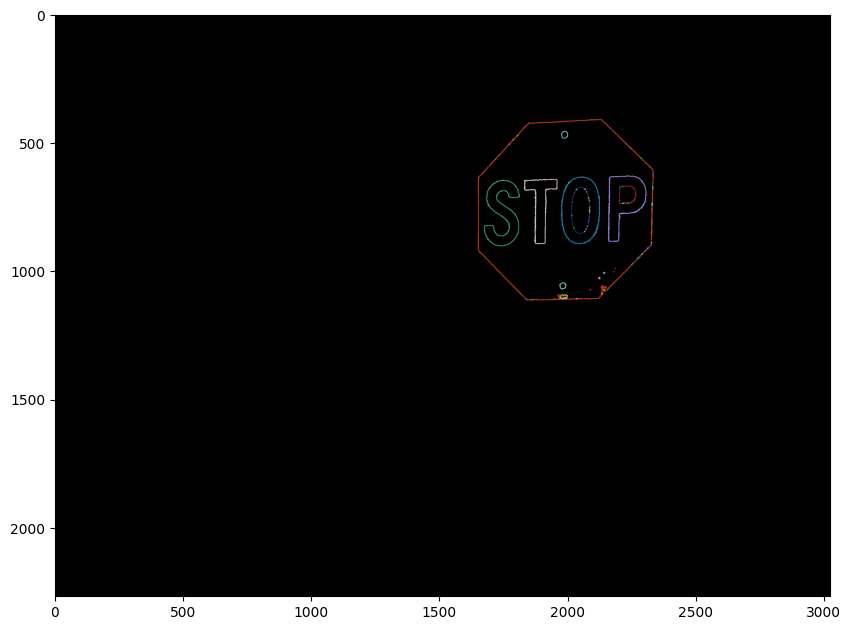

In [75]:
#source: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
import random as rng
rng.seed(12345)
img = cv2.imread('color_filter.png')
lower = np.array([144, 168, 118])
upper = np.array([179, 255, 255])

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower, upper)
filtered = cv2.bitwise_and(img, img, mask=mask)

grayImage = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 0, 128, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(blackAndWhiteImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours
drawing = np.zeros((blackAndWhiteImage.shape[0], blackAndWhiteImage.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
show_img(drawing)

In [76]:
for c in contours:
    if cv2.contourArea(c) > 35000:
        print(cv2.contourArea(c))

389423.0


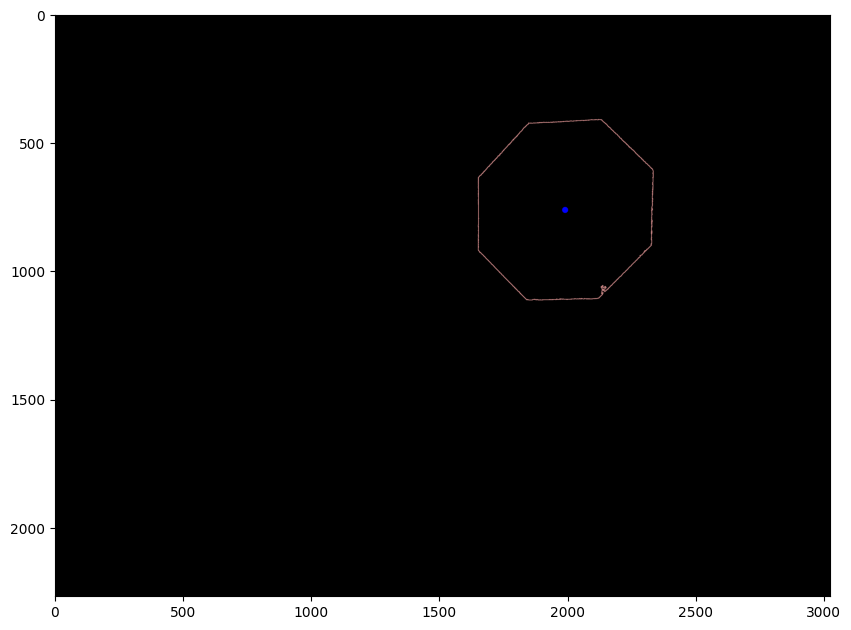

In [77]:
# Draw contours
drawing = np.zeros((blackAndWhiteImage.shape[0], blackAndWhiteImage.shape[1], 3), dtype=np.uint8)
filt_contours = []
for c in contours:
    if cv2.contourArea(c) > 35000:
        filt_contours.append(c)

for i in range(len(filt_contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(drawing, filt_contours, i, color, 2, cv2.LINE_8, hierarchy, 0)

M = cv2.moments(filt_contours[0])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
centroid = cv2.circle(drawing, (cx,cy), 2, (0,0,255), 20)

show_img(centroid)